<a href="https://colab.research.google.com/github/IlvaX/ProjectUnet/blob/main/UNET_Quantization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.23.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 88.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


In [ ]:
!pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 9.3 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

import tensorflow as tf
from tensorflow import keras
%matplotlib inline

RuntimeError: ignored

ImportError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_directory = '/content/drive/MyDrive/UNET Segmentation/source/'
mask_directory = '/content/drive/MyDrive/UNET Segmentation/masks/'

In [ ]:
SIZE = 256
num_images = 1400

Load images and masks in order so they match

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/UNET Segmentation/source/*.tif")
image_names.sort()
print(image_names)
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img, 0) for img in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

['/content/drive/MyDrive/UNET Segmentation/source/image_0_00.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_0_01.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_0_02.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_0_03.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_0_10.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_0_11.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_0_12.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_0_13.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_0_20.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_0_21.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_0_22.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_0_23.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_100_00.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_100_01.tif', '/content/drive/MyDrive/UNET Segmentation/source/image_100_02.tif', '/c

Read masks the same way. 

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/UNET Segmentation/masks/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (1400, 256, 256, 1)
Mask data shape is:  (1400, 256, 256, 1)
Max pixel value in image is:  227
Labels in the mask are :  [  0 255]


In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

# Original Model 

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=15, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/15
70/70 [==============================] - 96s 917ms/step - loss: 0.1706 - accuracy: 0.9506 - val_loss: 106.6688 - val_accuracy: 0.0660
Epoch 2/15
70/70 [==============================] - 59s 845ms/step - loss: 0.0623 - accuracy: 0.9819 - val_loss: 0.2446 - val_accuracy: 0.9302
Epoch 3/15
70/70 [==============================] - 60s 860ms/step - loss: 0.0450 - accuracy: 0.9861 - val_loss: 0.2000 - val_accuracy: 0.9427
Epoch 4/15
70/70 [==============================] - 61s 866ms/step - loss: 0.0354 - accuracy: 0.9886 - val_loss: 0.2791 - val_accuracy: 0.9369
Epoch 5/15
70/70 [==============================] - 61s 873ms/step - loss: 0.0316 - accuracy: 0.9891 - val_loss: 0.6833 - val_accuracy: 0.8309
Epoch 6/15
70/70 [==============================] - 61s 875ms/step - loss: 0.0272 - accuracy: 0.9905 - val_loss: 0.3408 - val_accuracy: 0.9369
Epoch 7/15
70/70 [==============================] - 60s 864ms/step - loss: 0.0212 - accuracy: 0.9925 - val_loss: 0.3127 - val_accuracy: 0.93

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

9/9 [==============================] - 30s 2s/step


In [ ]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9351727


In [ ]:
#Save the model for future use
#model.save('/content/drive/MyDrive/UNET Segmentation/_25epochs.hdf5')
model.save("/content/drive/MyDrive/UNET Segmentation/saved_model/")

(1, 256, 256, 1)
1/1 [==============================] - 2s 2s/step
(256, 256)


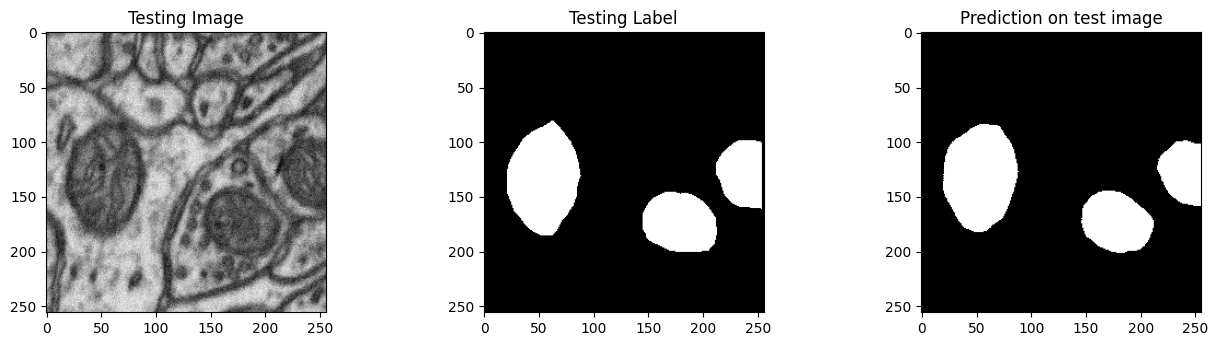

In [ ]:
import random

threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/UNET Segmentation/_15epochs.hdf5')

# Quantized Aware Training 

In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

ModuleNotFoundError: ignored

In [ ]:
# Accuracy after 2 epochs stays the same
# Tried with 15 epochs didn't work 
history = q_aware_model.fit(X_train,y_train, 
                  batch_size = 16, 
                  verbose=1, 
                  epochs=2, 
                  validation_data=(X_test, y_test), 
                  shuffle=False)

Epoch 1/2
70/70 [==============================] - 103s 1s/step - loss: nan - accuracy: 0.9396 - val_loss: nan - val_accuracy: 0.9369
Epoch 2/2
70/70 [==============================] - 84s 1s/step - loss: nan - accuracy: 0.9394 - val_loss: nan - val_accuracy: 0.9369


In [ ]:
#IOU
y_pred_q=q_aware_model.predict(X_test)
y_pred_thresholded_q = y_pred > 0.5

9/9 [==============================] - 4s 554ms/step


In [ ]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded_q, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9351727


(1, 256, 256, 1)
1/1 [==============================] - 0s 71ms/step
(256, 256)


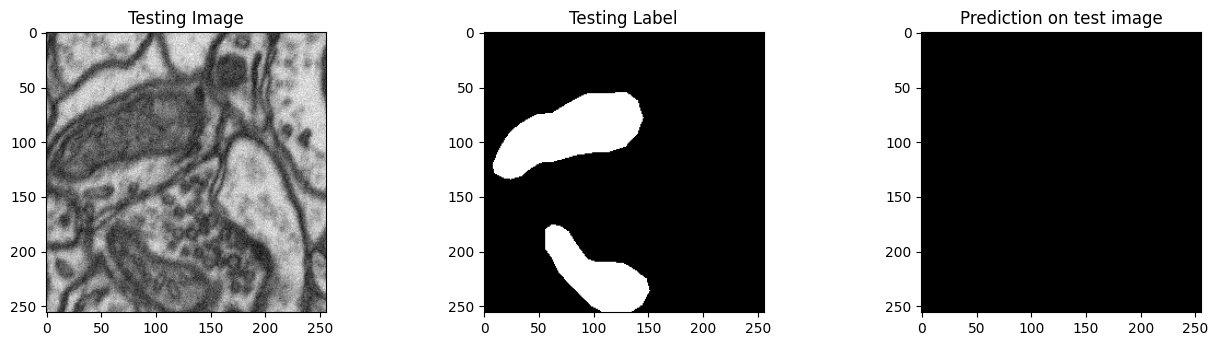

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (q_aware_model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
#Save the model for future use
q_aware_model.save("/content/drive/MyDrive/UNET Segmentation/quant_saved_model/_2epochs.hdf5")

# Post Training Quantization 

Only TF lite Conversion without quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/UNET Segmentation/saved_model")
tflite_model = converter.convert()

TF lite with quantization 

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/UNET Segmentation/saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

Size of different models 

In [ ]:
original = os.path.getsize("/content/drive/MyDrive/UNET Segmentation/_15epochs.hdf5")
quantized = os.path.getsize("/content/drive/MyDrive/UNET Segmentation/quant_saved_model/_2epochs.hdf5")

print((original/(1024*1024)))
print((quantized/(1024*1024)))
print((len(tflite_model)/(1024*1024)))                #tflite without quantization
print((len(tflite_quant_model)/(1024*1024)))          #tflite with quantization


355.682861328125
355.83197021484375
118.39067840576172
29.71154022216797
